### Imports

In [1]:
# Import libraries
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import math
from difflib import SequenceMatcher
import jellyfish # conda install -c conda-forge jellyfish 
from IPython.display import display
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
idx = pd.IndexSlice

---

### Scraping the data

#### Top universities

In [2]:
top_universities_url = 'https://www.topuniversities.com'
data_url = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt'

ranking = requests.get(data_url).text
ranking = json.loads(ranking)['data']
tu_ranking_dataframe = pd.io.json.json_normalize(ranking)
tu_ranking_dataframe.head()

,cc,core_id,country,guide,logo,nid,rank_display,region,score,stars,title,url
0,US,410,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",294850,1,North America,100,6,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...
1,US,573,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",297282,2,North America,98.7,5,Stanford University,/universities/stanford-university
2,US,253,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",294270,3,North America,98.4,5,Harvard University,/universities/harvard-university
3,US,94,United States,"<a href=""/where-to-study/north-america/united-...","<img src=""https://www.topuniversities.com/site...",294562,4,North America,97.7,5,California Institute of Technology (Caltech),/universities/california-institute-technology-...
4,GB,95,United Kingdom,"<a href=""/where-to-study/europe/united-kingdom...","<img src=""https://www.topuniversities.com/site...",294561,5,Europe,95.6,5,University of Cambridge,/universities/university-cambridge


In [3]:
fields_to_keep = ['title', 'rank_display', 'country', 'region', 'url']
tu_ranking_dataframe = tu_ranking_dataframe[fields_to_keep].set_index('rank_display')

# Keep the 200 first university
tu_ranking_dataframe = tu_ranking_dataframe[:200]
tu_ranking_dataframe.head()

,title,country,region,url
rank_display,,,,
1,Massachusetts Institute of Technology (MIT),United States,North America,/universities/massachusetts-institute-technolo...
2,Stanford University,United States,North America,/universities/stanford-university
3,Harvard University,United States,North America,/universities/harvard-university
4,California Institute of Technology (Caltech),United States,North America,/universities/california-institute-technology-...
5,University of Cambridge,United Kingdom,Europe,/universities/university-cambridge


In [4]:
# Inspect html of universities link (here mit)
mit_page = requests.get(top_universities_url + tu_ranking_dataframe.loc[:, 'url'][0]).text
mit_page = BeautifulSoup(mit_page, 'html.parser')

In [5]:
def get_total_faculty(uni_page):
    try:
        faculty_html = uni_page.find('div', class_='faculty-main')
        total_faculty_html = faculty_html.find('div', class_='total faculty')
        total_faculty_html = total_faculty_html.find('div', class_='number')
        total_faculty_num = int(total_faculty_html.contents[0].strip().replace(',', ''))
    except: 
        total_faculty_num = np.NaN
    return total_faculty_num

def get_inter_faculty(uni_page):
    try:
        faculty_html = uni_page.find('div', class_='faculty-main')
        inter_faculty_html = faculty_html.find('div', class_='inter faculty')
        inter_faculty_html = inter_faculty_html.find('div', class_='number')
        inter_faculty_num = int(inter_faculty_html.contents[0].strip().replace(',', ''))  
    except: 
        inter_faculty_num = np.NaN
    return inter_faculty_num

def get_total_student(uni_page):
    try:
        total_student_html = uni_page.find('div', class_='students-main')
        total_student_html = total_student_html.find('div', class_='number')
        total_student_num = int(total_student_html.contents[0].strip().replace(',', ''))
    except:
        total_student_num = np.NaN
    return total_student_num

def get_inter_student(uni_page):
    try:
        inter_student_html = uni_page.find('div', class_='int-students-main')
        inter_student_html = inter_student_html.find('div', class_='number')
        inter_student_num = int(inter_student_html.contents[0].strip().replace(',', ''))
    except:
        inter_student_num = np.NaN
    return inter_student_num

In [6]:
# Fetch all html pages
tu_ranking_dataframe.loc[:, 'html'] = tu_ranking_dataframe.loc[:, 'url'].map(lambda url: BeautifulSoup(requests.get(top_universities_url + url).text, 'html.parser'))


In [7]:
tu_ranking_dataframe.loc[:, 'Total faculty member'] = tu_ranking_dataframe.loc[:, 'html'].map(lambda html: get_total_faculty(html))
tu_ranking_dataframe.loc[:, 'International faculty member'] = tu_ranking_dataframe.loc[:, 'html'].map(lambda html: get_inter_faculty(html))
tu_ranking_dataframe.loc[:, 'Total student'] = tu_ranking_dataframe.loc[:, 'html'].map(lambda html: get_total_student(html))
tu_ranking_dataframe.loc[:, 'International student'] = tu_ranking_dataframe.loc[:, 'html'].map(lambda html: get_inter_student(html))

In [8]:
tu_ranking_dataframe.drop(['url', 'html'], axis=1, inplace=True)
tu_ranking_dataframe.head()

,title,country,region,Total faculty member,International faculty member,Total student,International student
rank_display,,,,,,,
1,Massachusetts Institute of Technology (MIT),United States,North America,2982.0,1679.0,11067.0,3717.0
2,Stanford University,United States,North America,4285.0,2042.0,15878.0,3611.0
3,Harvard University,United States,North America,4350.0,1311.0,22429.0,5266.0
4,California Institute of Technology (Caltech),United States,North America,953.0,350.0,2255.0,647.0
5,University of Cambridge,United Kingdom,Europe,5490.0,2278.0,18770.0,6699.0


In [9]:
# As we can see on the output below, 2 universities have missing values. 
tu_ranking_dataframe[tu_ranking_dataframe.isnull().any(axis=1)]

,title,country,region,Total faculty member,International faculty member,Total student,International student
rank_display,,,,,,,
52,New York University (NYU),United States,North America,NaN,NaN,NaN,NaN
190,Indian Institute of Science (IISc) Bangalore,India,Asia,423.0,NaN,4071.0,47.0


In [10]:
# A quick google search let us find the correct values
columns_to_replace = ['Total faculty member', 'International faculty member', 'Total student', 'International student']
tu_ranking_dataframe[51:52].loc[:, columns_to_replace] = [15286, 604, 58547, 15000]
tu_ranking_dataframe[189:190].loc[:, columns_to_replace] = [423, 0, 4071, 47]
tu_ranking_dataframe = tu_ranking_dataframe.reset_index()

---

#### Times

In [11]:
times_url = 'http://www.timeshighereducation.com'
times_data_url = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

ranking = requests.get(times_data_url).text
ranking = json.loads(ranking)['data']
times_ranking_dataframe = pd.io.json.json_normalize(ranking)
times_ranking_dataframe.head()

,aliases,location,member_level,name,nid,rank,rank_order,record_type,scores_citations,scores_citations_rank,...,scores_research,scores_research_rank,scores_teaching,scores_teaching_rank,stats_female_male_ratio,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,subjects_offered,url
0,University of Oxford,United Kingdom,0,University of Oxford,468,1,10,master_account,99.1,15,...,99.5,1,86.7,5,46 : 54,"20,409",38%,11.2,"Archaeology,Art, Performing Arts & Design,Biol...",/world-university-rankings/university-oxford
1,University of Cambridge,United Kingdom,0,University of Cambridge,470,2,20,master_account,97.5,29,...,97.8,3,87.8,3,45 : 55,"18,389",35%,10.9,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/university-cambridge
2,California Institute of Technology caltech,United States,0,California Institute of Technology,128779,=3,30,private,99.5,10,...,97.5,4,90.3,1,31 : 69,"2,209",27%,6.5,"Architecture,Biological Sciences,Business & Ma...",/world-university-rankings/california-institut...
3,Stanford University,United States,11,Stanford University,467,=3,40,private,99.9,4,...,96.7,5,89.1,2,42 : 58,"15,845",22%,7.5,"Archaeology,Architecture,Art, Performing Arts ...",/world-university-rankings/stanford-university
4,Massachusetts Institute of Technology,United States,0,Massachusetts Institute of Technology,471,5,50,private,100.0,1,...,91.9,9,87.3,4,37 : 63,"11,177",34%,8.7,"Architecture,Art, Performing Arts & Design,Bio...",/world-university-rankings/massachusetts-insti...


In [12]:
times_ranking_dataframe.columns

Index(['aliases', 'location', 'member_level', 'name', 'nid', 'rank',
       'rank_order', 'record_type', 'scores_citations',
       'scores_citations_rank', 'scores_industry_income',
       'scores_industry_income_rank', 'scores_international_outlook',
       'scores_international_outlook_rank', 'scores_overall',
       'scores_overall_rank', 'scores_research', 'scores_research_rank',
       'scores_teaching', 'scores_teaching_rank', 'stats_female_male_ratio',
       'stats_number_students', 'stats_pc_intl_students',
       'stats_student_staff_ratio', 'subjects_offered', 'url'],
      dtype='object')

In [13]:
fields_to_keep = ['name', 'rank', 'location', 'url']

times_ranking_dataframe = times_ranking_dataframe[fields_to_keep].set_index('rank')

# Keep the 200 first university
times_ranking_dataframe = times_ranking_dataframe[:200]
times_ranking_dataframe.head()

,name,location,url
rank,,,
1,University of Oxford,United Kingdom,/world-university-rankings/university-oxford
2,University of Cambridge,United Kingdom,/world-university-rankings/university-cambridge
=3,California Institute of Technology,United States,/world-university-rankings/california-institut...
=3,Stanford University,United States,/world-university-rankings/stanford-university
5,Massachusetts Institute of Technology,United States,/world-university-rankings/massachusetts-insti...


In [14]:
# For all universities fetch its information page
times_ranking_dataframe.loc[:, 'html'] = times_ranking_dataframe.loc[:, 'url'].map(lambda url: BeautifulSoup(requests.get(times_url + url).text, 'html.parser')) 

In [15]:
def get_total_student(uni_page):
    try:
        raw_value = uni_page.find('div', class_='keystats number_students').previousSibling.contents[0]
        value = int(raw_value.strip().replace(',', ''))
    except:
        value = np.NaN
    return value

def get_ratio_inter_student(uni_page):
    try:
        raw_value = uni_page.find('div', class_='keystats pc_intl_students').previousSibling.contents[0]
        value = float(raw_value.strip().replace('%', '')) / 100 
    except:
        value = np.NaN
    return value

def get_ratio_faculty_member(uni_page):
    try:
        raw_value = uni_page.find('div', class_='keystats student_staff_ratio').previousSibling.contents[0]
        value = 1 / float(raw_value.strip().replace('%', '')) 
    except:
        value = np.NaN
    return value

def get_all_values(uni_page):
    total_student = get_total_student(uni_page)
    inter_student = math.ceil(get_ratio_inter_student(uni_page) * total_student)
    total_faculty_member = math.ceil(get_ratio_faculty_member(uni_page) * total_student)
    return [total_student, inter_student, total_faculty_member]

In [16]:
times_ranking_dataframe.loc[:, 'Total student'] = times_ranking_dataframe.loc[:, 'html'].map(lambda html: get_total_student(html))
times_ranking_dataframe.loc[:, 'International student'] = times_ranking_dataframe.loc[:, 'html'].map(lambda html: get_ratio_inter_student(html)) * times_ranking_dataframe.loc[:, 'Total student']
times_ranking_dataframe.loc[:, 'Faculty member'] = times_ranking_dataframe.loc[:, 'html'].map(lambda html: get_ratio_faculty_member(html)) * times_ranking_dataframe.loc[:, 'Total student']

columns_to_keep = ['rank', 'name', 'location', 'Total student', 'International student', 'Faculty member']
times_ranking_dataframe = times_ranking_dataframe.reset_index().loc[:, columns_to_keep] 


---
# 2 final rankings' Dataframes

In [17]:
# renaming rank to have the same name in both df
tu_ranking_dataframe.rename(columns = {'rank_display':'rank'}, inplace = True)
# setting the school name as an index, since this will determine the merging of 2 dataframes
tu_ranking_dataframe.set_index('title', inplace = True)
#showing resulting df
tu_ranking_dataframe.head()

,rank,country,region,Total faculty member,International faculty member,Total student,International student
title,,,,,,,
Massachusetts Institute of Technology (MIT),1,United States,North America,2982.0,1679.0,11067.0,3717.0
Stanford University,2,United States,North America,4285.0,2042.0,15878.0,3611.0
Harvard University,3,United States,North America,4350.0,1311.0,22429.0,5266.0
California Institute of Technology (Caltech),4,United States,North America,953.0,350.0,2255.0,647.0
University of Cambridge,5,United Kingdom,Europe,5490.0,2278.0,18770.0,6699.0


In [18]:
times_ranking_dataframe.set_index('name', inplace = True)
times_ranking_dataframe.head()

,rank,location,Total student,International student,Faculty member
name,,,,,
University of Oxford,1,United Kingdom,20409,7755.42,1822.232143
University of Cambridge,2,United Kingdom,18389,6436.15,1687.064220
California Institute of Technology,=3,United States,2209,596.43,339.846154
Stanford University,=3,United States,15845,3485.90,2112.666667
Massachusetts Institute of Technology,5,United States,11177,3800.18,1284.712644


## Answering questions for Top Universities
### Faculty_members/students ratio

In [19]:
nr_stud        = tu_ranking_dataframe['Total student'];
nr_fac_mem     = tu_ranking_dataframe['Total faculty member'];
nr_int_stud    = tu_ranking_dataframe['International student'];

stud_fac_ratio = nr_fac_mem/nr_stud;
stud_int_ratio = nr_int_stud/nr_stud;

tu_ranking_dataframe['Faculty / Student ratio'] = stud_fac_ratio;
tu_ranking_dataframe['International Students ratio'] = stud_int_ratio;

by_country = pd.DataFrame( tu_ranking_dataframe.groupby(['country'])['Faculty / Student ratio'].max() );
by_country.sort_values(['Faculty / Student ratio'], ascending = False, inplace=True)
pd.options.display.float_format = '{:.2f}'.format
print('TOP 3 countires with Faculty / Student ratio ratio from Top Universities')

display(by_country.head(3))
by_region = pd.DataFrame( tu_ranking_dataframe.groupby(['region'])['Faculty / Student ratio'].max() );
by_region.sort_values(['Faculty / Student ratio'], ascending = False, inplace=True)
print('TOP 3 regions with Faculty / Student ratio ratio from Top Universities')
display(by_region.head(3))

TOP 3 countires with Faculty / Student ratio ratio from Top Universities


,Faculty / Student ratio
country,
United States,0.42
United Kingdom,0.34
Denmark,0.24


TOP 3 regions with Faculty / Student ratio ratio from Top Universities


,Faculty / Student ratio
region,
North America,0.42
Europe,0.34
Asia,0.21


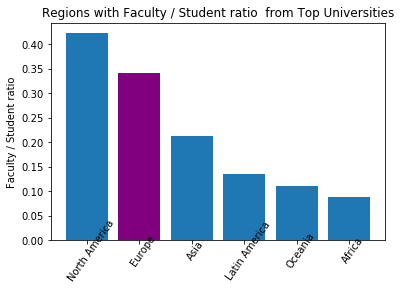

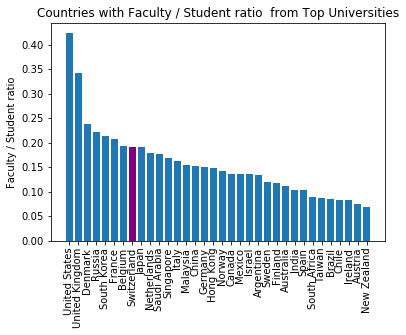

In [20]:
plt.figure(1)
values = by_region.head(10)['Faculty / Student ratio'].values
length = len(values)
names = by_region.head(10)['Faculty / Student ratio'].index
plt.bar(range(0,length), values)
plt.bar(1,values[1], color='purple') # set Europe to purple
plt.xticks(range(0,length), names, rotation=55, rotation_mode='anchor')
plt.ylabel('Faculty / Student ratio')
plt.title('Regions with Faculty / Student ratio  from Top Universities')
plt.figure(2)
values = by_country['Faculty / Student ratio'].values
length = len(values)
names = by_country['Faculty / Student ratio'].index
plt.bar(range(0,length), values)
plt.bar(7,values[7], color='purple') # set CH to purple
plt.xticks(range(0,length), names, rotation=90)
plt.ylabel('Faculty / Student ratio')
plt.title('Countries with Faculty / Student ratio  from Top Universities')
plt.show()


### International Students

In [21]:
by_country = pd.DataFrame( tu_ranking_dataframe.groupby(['country'])['International Students ratio'].max() );
by_country.sort_values(['International Students ratio'], ascending = False, inplace=True)
print('TOP 3 countries with Int. students ratio from Top Universities')
display(by_country.head(3))
by_region = pd.DataFrame( tu_ranking_dataframe.groupby(['region'])['International Students ratio'].max() );
by_region.sort_values(['International Students ratio'], ascending = False, inplace=True)
print('TOP 3 regions with Int. students ratio from Top Universities')
display(by_region.head(3))

TOP 3 countries with Int. students ratio from Top Universities


,International Students ratio
country,
United Kingdom,0.69
Switzerland,0.57
Netherlands,0.50


TOP 3 regions with Int. students ratio from Top Universities


,International Students ratio
region,
Europe,0.69
North America,0.48
Oceania,0.43


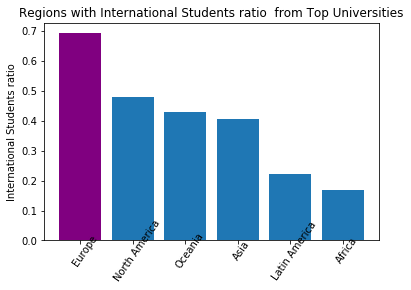

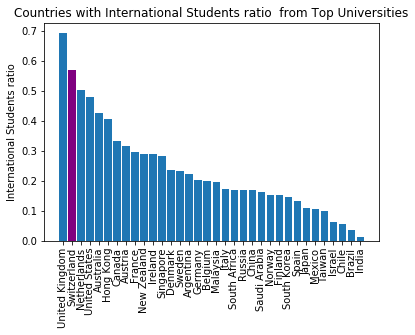

In [22]:
plt.figure(1)
values = by_region.head(10)['International Students ratio'].values
length = len(values)
names = by_region.head(10)['International Students ratio'].index
plt.bar(range(0,length), values)
plt.bar(0,values[0], color='purple') # set Europe to purple
plt.xticks(range(0,length), names, rotation=55, rotation_mode='anchor')
plt.ylabel('International Students ratio')
plt.title('Regions with International Students ratio  from Top Universities')
plt.figure(2)
values = by_country['International Students ratio'].values
length = len(values)
names = by_country['International Students ratio'].index
plt.bar(range(0,length), values)
plt.bar(1,values[1], color='purple') # set switzerland to purple
plt.xticks(range(0,length), names, rotation=90)

plt.ylabel('International Students ratio')
plt.title('Countries with International Students ratio  from Top Universities')
plt.show()


## Answers for Times High Education

### Faculty members/students ratio

TOP 3 Locations with Faculty / Students ratio from  Times High Education


,Faculty / Students ratio
location,
United States,0.30
Denmark,0.24
France,0.20


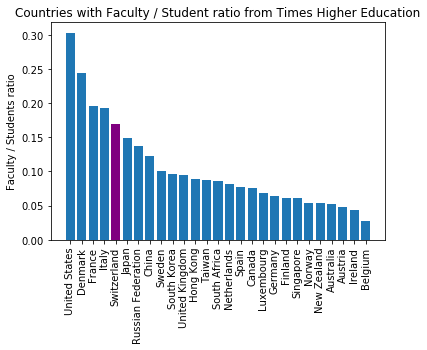

In [23]:
nr_stud        = times_ranking_dataframe['Total student'];
nr_fac_mem     = times_ranking_dataframe['Faculty member'];
nr_int_stud    = times_ranking_dataframe['International student'];

stud_fac_ratio = nr_fac_mem/nr_stud;
stud_int_ratio = nr_int_stud/nr_stud;

times_ranking_dataframe['Faculty / Students ratio'] = stud_fac_ratio;
times_ranking_dataframe['International Students ratio'] = stud_int_ratio;

times_ranking_dataframe['Faculty / Students ratio'] = stud_fac_ratio;
by_country = pd.DataFrame( times_ranking_dataframe.groupby(['location'])['Faculty / Students ratio'].max() );
by_country.sort_values(['Faculty / Students ratio'], ascending = False, inplace=True)
print('TOP 3 Locations with Faculty / Students ratio from  Times High Education')
display(by_country.head(3))

plt.figure(1)
values = by_country['Faculty / Students ratio'].values
length = len(values)
names = by_country['Faculty / Students ratio'].index
plt.bar(range(0,length), values)
plt.bar(4,values[4], color='purple') # set CH to purple
plt.xticks(range(0,length), names, rotation=90)
plt.ylabel('Faculty / Students ratio')
plt.title('Countries with Faculty / Student ratio from Times Higher Education')
plt.show()

TOP 3 Locations with In. Student ratio from  Times High Education


,International Students ratio
location,
United Kingdom,0.71
Luxembourg,0.57
Switzerland,0.55


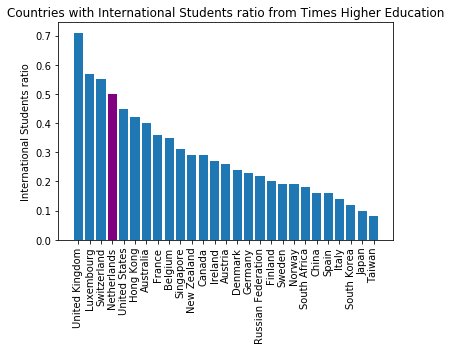

In [24]:
by_country = pd.DataFrame( times_ranking_dataframe.groupby(['location'])['International Students ratio'].max() );
by_country.sort_values(['International Students ratio'], ascending = False, inplace=True)
print('TOP 3 Locations with In. Student ratio from  Times High Education')
display(by_country.head(3))

plt.figure(1)
values = by_country['International Students ratio'].values
length = len(values)
names = by_country['International Students ratio'].index
plt.bar(range(0,length), values)
plt.bar(3,values[3], color='purple') # set Europe to purple
plt.xticks(range(0,length), names, rotation=90)
plt.ylabel('International Students ratio')
plt.title('Countries with International Students ratio from Times Higher Education')
plt.show()

# Merging the Data Frames

## Matching the index names - creating name-TU and name-TIMES similarity matrix

To match the university names, we do multiple operations:
0. Make everything uppercase e.g. "University of Baden" -> "UNIVERISTY OF BADEN"
1. Remove ambigous words such as spaces or "university" "institute" etc. e.g. "UNIVERISTY OF BADEN"-> "BADEN" 
2. Compute a (-1,1) similarity value basen on hamming string distance for all the names
3. When comparing the string, check if they contain each other and if yes, what is the number of remaining characters. If they contain one another and the difference is less than 5 chars, we consider them as almost equal (0.99) and deny the similarity.
4. Match names with similarity >0.74 , all the others --> add as separate names.

## Example of string similarity function
the similarity between <br>"Massachusetts Institute of Technology (MIT)" <br>
                       "Massachusetts Institute of Technology"<br> 
is 0.99, because one string contains another<br>
<br>
the similarity between <br>
     "ETH Zurich - Swiss Federal Institute of Technology" <br>
     "ETH Zurich - Swiss Federal Institute of Technology Zurich"<br>
 is 0.85, because of the Hamming distance coefficient.<br>

In [25]:
def remove_nonexplicit_words(a):
    a = a.upper();
    a = a.replace('INSTITITE OF','')
    a = a.replace('UNIVERSITY OF' ,'')
    a = a.replace('UNIVERSITY','')
    a = a.replace('Ecole normale supérieure'.upper(),'')
    a = a.replace('École Normale Supérieure'.upper(),'')   
    a = a.replace(' DE ','')
    a = a.replace(' DI ','')
    a = a.replace('THE','')
    a = a.replace(' ','')
    a = a.replace('(','')
    a = a.replace(')','')
    return a;

#reutrns similarity between 2 strings
def similarity_str(a, b):
    if a == b:                         # if the strings are exactly the same
        return 1;
    a = remove_nonexplicit_words(a);
    b = remove_nonexplicit_words(b);
    if a in b:                         # if b contains a
        if len(b.replace(a,'')) < 5 :  # if additional chars in the difference are less than 5
            return 0.99;
    if b in a:                         # if a contains b
        if len(a.replace(b,'')) < 5 :  # if additional chars in the difference are less than 5
            return 0.99;
    length = np.max((len(a), len(b)));
    # else, return the hamming distance coeff
    return 1-jellyfish.hamming_distance(a,b)/length#(SequenceMatcher(None, a, b).ratio())

# this dataframe will conatain similarity values between uni names in tu and times dataframes
similarity_matrix = pd.DataFrame(columns=times_ranking_dataframe.index, index=tu_ranking_dataframe.index)

# fill in the inter-index similarity values
for tu_index_str in tu_ranking_dataframe.index:
    for times_index_str in times_ranking_dataframe.index:
        similarity_matrix.loc[tu_index_str][times_index_str] = similarity_str(tu_index_str, times_index_str)

similarity_matrix.index.name = 'Name in TU df'
similarity_matrix.columns.name = 'Name in TIMES df  / similarity'
pd.options.display.float_format = '{:.3f}'.format
similarity_matrix.head(10)
#e.g. that the similarity between "Massachusetts Institute of Technology (MIT)" 
# and                             "Massachusetts Institute of Technology" 
# is 0.99, because one string contains another

# and the similarity between 
#        "ETH Zurich - Swiss Federal Institute of Technology" 
# and    "ETH Zurich - Swiss Federal Institute of Technology Zurich"
# is 0.85, because of the Hamming distance

Name in TIMES df / similarity,University of Oxford,University of Cambridge,California Institute of Technology,Stanford University,Massachusetts Institute of Technology,Harvard University,Princeton University,Imperial College London,University of Chicago,ETH Zurich – Swiss Federal Institute of Technology Zurich,...,University of Massachusetts,University of Auckland,Northeastern University,Lomonosov Moscow State University,Tilburg University,Paris-Sorbonne University – Paris 4,"Royal Holloway, University of London","University of California, Riverside",University of Gothenburg,National Taiwan University
Name in TU df,,,,,,,,,,,,,,,,,,,,,
Massachusetts Institute of Technology (MIT),0.000,0.027,0.054,0.000,0.990,0.054,0.000,0.000,0.027,0.020,...,0.351,0.000,0.000,0.081,0.000,0.027,0.000,0.054,0.000,0.027
Stanford University,0.000,0.000,0.097,1,0.000,0.000,0.111,0.000,0.000,0.020,...,0.000,0.125,0.000,0.050,0.000,0.000,0.000,0.150,0.000,0.000
Harvard University,0.000,0.222,0.032,0.000,0.059,1,0.000,0.000,0.143,0.020,...,0.154,0.000,0.111,0.000,0.143,0.095,0.000,0.050,0.143,0.071
California Institute of Technology (Caltech),0.000,0.053,0.816,0.079,0.053,0.026,0.000,0.026,0.026,0.020,...,0.053,0.000,0.000,0.026,0.026,0.079,0.000,0.263,0.000,0.105
University of Cambridge,0.111,1,0.065,0.000,0.029,0.222,0.000,0.095,0.111,0.000,...,0.077,0.000,0.000,0.050,0.111,0.048,0.000,0.100,0.111,0.071
University of Oxford,1,0.111,0.000,0.000,0.000,0.000,0.000,0.048,0.000,0.000,...,0.000,0.000,0.000,0.050,0.000,0.000,0.000,0.000,0.000,0.000
UCL (University College London),0.000,0.000,0.032,0.000,0.029,0.000,0.000,0.048,0.062,0.000,...,0.062,0.000,0.000,0.000,0.062,0.048,0.000,0.050,0.000,0.062
Imperial College London,0.048,0.095,0.032,0.000,0.000,0.000,0.000,1,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.095,0.095,0.000,0.095
University of Chicago,0.000,0.111,0.032,0.000,0.029,0.143,0.111,0.000,1,0.000,...,0.077,0.000,0.000,0.000,0.000,0.000,0.050,0.050,0.000,0.000


### Merge names depending on index name similarity value 
#### ( > 74% similar to merge, otherwise considered as separate)

In [26]:
# Chosing the merging choice depending on similarity value
max_col_names = similarity_matrix.idxmax(axis=1);
max_values = similarity_matrix.max(axis=1);

# magic constant 0.74, similarity string limit above which we consider unis the same
max_col_names[max_values < 0.74] = 'unknown' 

similarity_matrix['decision'] = max_col_names;

### Correcting the names in Top Universities Dataset (TU)  to the matching ones in TIMES
notice that now <br>
the 1st row is  "Massachusetts Institute of Technology" <br>
not like before "Massachusetts Institute of Technology (MIT)"<br>
because of the name matching

In [27]:
corr_names = similarity_matrix[['decision']].query('decision!="unknown"').query('decision!="equal"')['decision'];

# replacing names in TU with the names in TIMES (the decision)
rename_dictionary = dict(zip(corr_names.index, corr_names.values))
tu_ranking_dataframe.rename(rename_dictionary, inplace = True)
times_ranking_dataframe.index.name = ''

# showing the result - notice that now 
# the 1st row is  "Massachusetts Institute of Technology"
# not like before "Massachusetts Institute of Technology (MIT)"
tu_ranking_dataframe.head(3)

,rank,country,region,Total faculty member,International faculty member,Total student,International student,Faculty / Student ratio,International Students ratio
Name in TU df,,,,,,,,,
Massachusetts Institute of Technology,1,United States,North America,2982.000,1679.000,11067.000,3717.000,0.269,0.336
Stanford University,2,United States,North America,4285.000,2042.000,15878.000,3611.000,0.270,0.227
Harvard University,3,United States,North America,4350.000,1311.000,22429.000,5266.000,0.194,0.235


### Merging TU and TIMES dataframes
Now the matching index names are the same, so we can merge 2 dataframes

In [28]:
#adding subcolumns above the merge to separate 2 datasets
tu_ranking_dataframe = pd.concat([tu_ranking_dataframe], axis=1, keys=['Top Universities'])
times_ranking_dataframe = pd.concat([times_ranking_dataframe], axis=1, keys=['Times Higher Education'])

#merging the dataframes
merged_dataframes = times_ranking_dataframe.join(tu_ranking_dataframe, how='outer')

# replace '=3' with (float)3 
for idx in merged_dataframes[[('Times Higher Education', 'rank')]].index:
    val_TIMES = float(str(merged_dataframes[('Times Higher Education', 'rank')][idx]).replace('=',''));
    val_TU = float(str(merged_dataframes[('Top Universities', 'rank')][idx]).replace('=',''));
    merged_dataframes[('Times Higher Education', 'rank')][idx] = val_TIMES
    merged_dataframes[('Top Universities', 'rank')][idx] = val_TU
    if(val_TIMES != np.nan and val_TU != np.nan):
        merged_dataframes.loc[idx,'Mean rank'] = np.sqrt(val_TIMES*val_TU, dtype=float)
    #print(np.floor(np.sqrt(val_TIMES*val_TU)))

# sorting in ('TIMES', 'rank') values
merged_dataframes.sort_values([('Times Higher Education', 'rank') ], ascending = True, inplace=True)

# changing display options for floating point
pd.options.display.float_format = '{:.0f}'.format
merged_dataframes[('Times Higher Education','International Students ratio')] = merged_dataframes[('Times Higher Education','International Students ratio')].map('{:.2f}'.format)
merged_dataframes[('Times Higher Education','Faculty / Students ratio')] = merged_dataframes[('Times Higher Education','Faculty / Students ratio')].map('{:.2f}'.format)
merged_dataframes[('Top Universities','International Students ratio')] = merged_dataframes[('Top Universities','International Students ratio')].map('{:.2f}'.format)
merged_dataframes[('Top Universities','Faculty / Student ratio')] = merged_dataframes[('Top Universities','Faculty / Student ratio')].map('{:.2f}'.format)

# showing the results
merged_dataframes.head(10)
merged_dataframes_temp = merged_dataframes

### Correlation Analysis

In [29]:
# setting the values as float
ranklist1 = np.array(merged_dataframes_temp['Times Higher Education','rank'])
ranklist1 = ranklist1.astype(np.float)
merged_dataframes_temp['Times Higher Education','rank']=ranklist1

ranklist2 = np.array(merged_dataframes_temp['Top Universities','rank'])
ranklist2 = ranklist2.astype(np.float)
merged_dataframes_temp['Top Universities','rank']=ranklist2
print(type(merged_dataframes_temp['Times Higher Education','Faculty / Students ratio'][1]))
pd.options.display.float_format = '{:.3f}'.format

faculty_to_studentsratio1 = np.array(merged_dataframes_temp['Times Higher Education','Faculty / Students ratio'])
faculty_to_studentsratio1 = faculty_to_studentsratio1.astype(np.float)
merged_dataframes_temp['Times Higher Education','Faculty / Students ratio']=faculty_to_studentsratio1

faculty_to_studentsratio2 = np.array(merged_dataframes_temp['Top Universities','Faculty / Student ratio'])
faculty_to_studentsratio2 = faculty_to_studentsratio2.astype(np.float)
merged_dataframes_temp['Top Universities','Faculty / Student ratio']=faculty_to_studentsratio2

international_studentsratio1 = np.array(merged_dataframes_temp['Times Higher Education','International Students ratio'])
international_studentsratio1 = international_studentsratio1.astype(np.float)
merged_dataframes_temp['Times Higher Education','International Students ratio']=international_studentsratio1

international_studentsratio2 = np.array(merged_dataframes_temp['Times Higher Education','International Students ratio'])
international_studentsratio2 = international_studentsratio2.astype(np.float)
merged_dataframes_temp['Top Universities','International Students ratio']= international_studentsratio2

merged_dataframes_temp.corr(method = 'pearson', min_periods=1)
#merged_dataframes_temp

<class 'str'>


Times Higher Education  \
                                                                      rank   
Times Higher Education rank                                          1.000   
                       Total student                                -0.152   
                       International student                        -0.328   
                       Faculty member                               -0.249   
                       Faculty / Students ratio                     -0.147   
                       International Students ratio                 -0.214   
Top Universities       rank                                          0.708   
                       Total faculty member                         -0.350   
                       International faculty member                 -0.363   
                       Total student                                -0.160   
                       International student                        -0.276   
                       Faculty / Student ratio                      -0.315   
                       International Students ratio                 -0.214   
Mean rank                                                            0.919   

                                                                   \
                                                    Total student   
Times Higher Education rank                                -0.152   
                       Total student                        1.000   
                       International student                0.578   
                       Faculty member                       0.568   
                       Faculty / Students ratio            -0.315   
                       International Students ratio        -0.290   
Top Universities       rank                                -0.012   
                       Total faculty member                 0.576   
                       International faculty member         0.267   
                       Total student                        0.981   
                       International student                0.578   
                       Faculty / Student ratio             -0.374   
                       International Students ratio        -0.290   
Mean rank                                                  -0.097   

                                                                           \
                                                    International student   
Times Higher Education rank                                        -0.328   
                       Total student                                0.578   
                       International student                        1.000   
                       Faculty member                               0.276   
                       Faculty / Students ratio                    -0.252   
                       International Students ratio                 0.499   
Top Universities       rank                                        -0.280   
                       Total faculty member                         0.419   
                       International faculty member                 0.525   
                       Total student                                0.572   
                       International student                        0.924   
                       Faculty / Student ratio                     -0.183   
                       International Students ratio                 0.499   
Mean rank                                                          -0.311   

                                                                    \
                                                    Faculty member   
Times Higher Education rank                                 -0.249   
                       Total student                         0.568   
                       International student                 0.276   
                       Faculty member                        1.000   
                       Faculty / Students rat

Looking at the above table, we will go attribute by attribute and try to interpret its correlation value with the other attributes. First, we note that under *rank*, the negative sign of the correlation means positive sign for the university standing as the less rank the university has, the better:

The below points are almost the same for both Rankings. Here, we are only discussing correlation between columns of the same rankings. The next chunk will deal with the most important correlation points between the two different rankings:

## Correlation Analysis for Columns Belonging to Same Ranking

1. *Total Student* with:
    - **International Student** : A strong positive correlation exists between the two since usually, the higher the number of students in a university, the more famous it is and thus it will attract more international students. So, whenever total number of students is high in a university, the number of international students is expected to be high as well. 
    
    - **Faculty Member**: Also, a strongpositive correlation exists between these two attributes. This is not surprising since the more students a university has, the more faculty members (professors, teacher assistants, janitors...) the university should hire.
    
    - **Faculty / Student Ratio**: A somewhat strong correlation exists here. This is mainly due to the fact that students is in the numerator. One might think that the correlation here should be maximally 1 as whenever students will increase, the ratio should increase as strongly. However, one should pay attention to the fact that whenevr number of students increases, the number of faculty members will increase as well, thus keeping the ratio somehow constant. Also,we can see here that whenever number of students increase, the change in faculty members numbers increases.
    
    - ** International Students Ratio**: A somewhat strong negative correlation here implies that whenever there are more students in a university, the ratio of international students in that university is bound to be less compared to a university with less students. It is worthy to note here that this is not contradictory to what has been said previously when discussing the correlation between *Total Student* and *International Student* as here we are talking about the ratio and not the actual number of international students.
    
    - **Rank**: A slight negative correlation exists here indicating that the more the number of students a university has, it will be, on average, slightly better ranked than another university with a lower number of students.
    
2. *International Student* with:
    - **Total Student**: Already discussed.
    
    - **Faculty Member**: A small positive correlation depicts a similar reasoning to that between number of students and number of faculty members. A slight annex to the above reasonning would be that, as discussed above, the more students there are, the more international students there are. And, since there's a positive correlation between number of students and number of faculty members, this correlation is thus traveled to international students as well, but less acute.
    
    - **Faculty / Student Ratio**: Low correaltion, will not discuss.
    - **International Students ratio**: A strong correlation exists here and with no surprise. The more international students there are in a university, the higher the ratio of international students. Interpreting this, we can say that the increase of international students in a university will be stronger to the total number of students.
    - **Rank**: A somewhat stronger correlation exists between these two attributes. This is saying that the better a university is ranked, the more international students it has, on average. However, what would be more interesting is the ratio of international students' effect on rank.
 
3.  *Faculty Members* with:
    - **Total Student**: Already discussed.
    - **International Student**: Already discussed.
    - **Faculty / Student Ratio**: A strongly negative value for these two is of no surprise. The more faculty members we have, the less the students to faculty ratio is going to be.
    - **International Students ratio**: A somewhat negative correlation exists. The more faculty members a university has, the less international students it has, on average. No further comment.
    - **Rank**: A negative correlation of some significance. More faculty members means better ranking on average. This is logical since the more faculty members, the more contributions and publications the faculty staff will have and thus contributing more to the university's score. 

4. *Faculty / Student Ratio* with:
    - **Total Student**: Already discussed.
    - **International Student**: Already discussed.
    - ** Faculty Members**: Already discussed.
    - **International Students ratio**: Weak negative correlation.
    - **Rank**: POSITIVE correaltion and of course, this is only logical. This means that the more students a university has compared to its number of students, the less "teaching attention" is delivered to students on average and thus the worse the university will perform, on average. Also, it's probably due to the fact that this ratio is an important element in scoring for the university rankings.
5. International Students ratio with:
    -  **Total Student**: Already discussed.
    - **International Student**: Already discussed.
    - ** Faculty Members**: Already discussed.
    - **Faculty / Student Ratio**: Already discussed.
    - **Rank**: Somewhat strong negative correlation. Aside from the fact that this element could be a big part of scoring also, one can justify the correlation with the following: The better the university, the more it is famous and the more it will attract international student. The more international students, the higher the international students ratio.
  
6. (Exceptionally for "Top Univerisities Ranking") International Faculty Member with:
    - **Rank**: A strong correlation value here indicates that universities with better rank have more international faculty members on average. This is significant since it shows a possibility that *Top Universities*'s score for universities depends on the number of international faculty members.
    - **International Students**: Another strong positive correlation value here showing that the more international students a university has, the more international faculty members it has on average. This will in turn, affect the international students ratio positively.
    
## Correlation Analysis for Columns Interchaged Between the Two Rankings

Of course, the high correlation values exist between columns of the same attributes. So the *International Number of Students* will move almost exactly the same between the two rankings. 

An interesting correlation value to look at is between the two different rank lists. The value is only 0.7, a a high value, true. But, is it high enough given that these are indicating the ranks for the same universities? 

Another interesting correlation values are between our mean rank and the two different ranks. We can see that our mean rank is slightly more correlated with that of *Top Universities*.

# Creating A Global Ranking (Geometric Mean of 2 ranks)
The Geometric mean ( sqrt(x*y) ) was chosen, because it favourizes the smallest values, eg geom_mean(2,200)=20 .
We believe, that it if the university is very high in one ranking and a biut smaller in the other, we should favourize the toppest ranking, since it's already a huge effort to be high in one of them. Of course if the university will have both very high, the geometric ranking will be even higher. 

In [30]:
# sorting in 'Our rank' values
merged_dataframes.sort_values(['Mean rank' ], ascending = True, inplace=True)

val = merged_dataframes['Mean rank'] 
val[:] = range(1,len(merged_dataframes)+1);
merged_dataframes['Our rank'] = val

# changing display options for floating point
pd.options.display.float_format = '{:,.0f}'.format

# showing the results
merged_dataframes = merged_dataframes[['Our rank','Times Higher Education','Top Universities']];
merged_dataframes.head(10)

Our rank  \
                                                              
Massachusetts Institute of Technology                     1   
University of Oxford                                      2   
Stanford University                                       3   
University of Cambridge                                   4   
California Institute of Technology                        5   
Harvard University                                        6   
Imperial College London                                   7   
University of Chicago                                     8   
Princeton University                                      9   
ETH Zurich – Swiss Federal Institute of Technol...       10   

                                                   Times Higher Education  \
                                                                     rank   
Massachusetts Institute of Technology                                   5   
University of Oxford                                                    1   
Stanford University                                                     3   
University of Cambridge                                                 2   
California Institute of Technology                                      3   
Harvard University                                                      6   
Imperial College London                                                 8   
University of Chicago                                                   9   
Princeton University                                                    7   
ETH Zurich – Swiss Federal Institute of Technol...                     10   

                                                                    \
                                                          location   
Massachusetts Institute of Technology                United States   
University of Oxford                                United Kingdom   
Stanford University                                  United States   
University of Cambridge                             United Kingdom   
California Institute of Technology                   United States   
Harvard University                                   United States   
Imperial College London                             United Kingdom   
University of Chicago                                United States   
Princeton University                                 United States   
ETH Zurich – Swiss Federal Institute of Technol...     Switzerland   

                                                                  \
                                                   Total student   
Massachusetts Institute of Technology                     11,177   
University of Oxford                                      20,409   
Stanford University                                       15,845   
University of Cambridge                                   18,389   
California Institute of Technology                         2,209   
Harvard University                                        20,326   
Imperial College London                                   15,857   
University of Chicago                                     13,525   
Princeton University                                       7,955   
ETH Zurich – Swiss Federal Institute of Technol...        19,233   

                                                                          \
                                                   International student   
Massachusetts Institute of Technology                              3,800   
University of Oxford                                               7,755   
Stanford University                                                3,486   
University of Cambridge                                            6,436   
California Institute of Technology                                   596   
Harvard University                                                 5,285   
Imperial College London                                            8,721   
University of Chicago      